# Velocity Verlet Integrator for a Gaussian Target

This notebook demonstrates how to use the velocity verlet integrator from Blackjax to simulate Hamiltonian dynamics for a Gaussian target distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

import blackjax
from blackjax.mcmc import integrators
from blackjax.mcmc import metrics
from blackjax.types import ArrayTree

# Set random seed for reproducibility
rng_key = jax.random.key(42)

## Define a Gaussian Target Distribution

We'll use a 2D Gaussian distribution as our target. The log-density function is defined as:

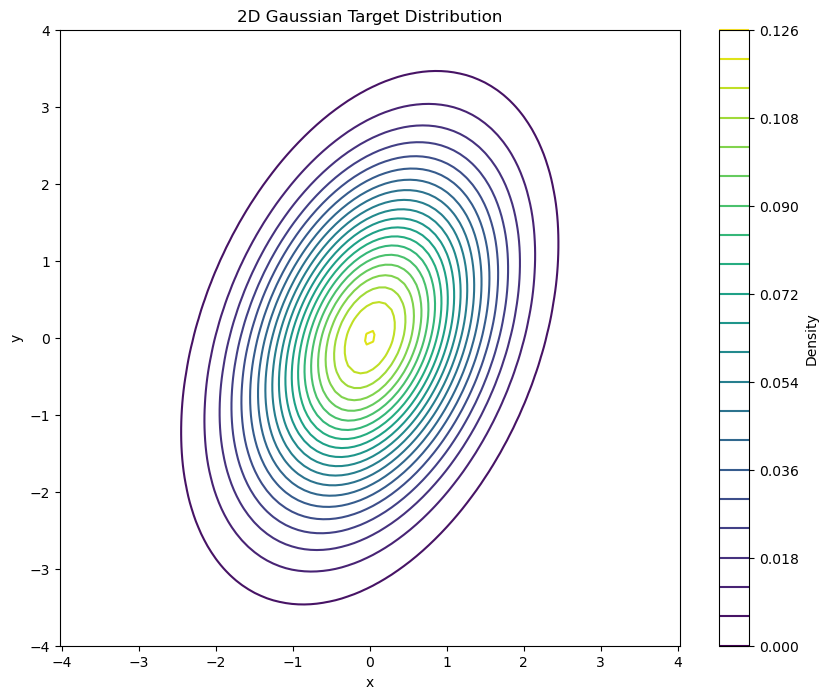

In [2]:
# Define the parameters of the Gaussian
mean = jnp.array([0.0, 0.0])
cov = jnp.array([[1.0, 0.5], [0.5, 2.0]])

# Define the log-density function
def logdensity_fn(position):
    return stats.multivariate_normal.logpdf(position, mean, cov)

# Visualize the target distribution
def plot_gaussian():
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            Z[i, j] = np.exp(logdensity_fn(np.array([X[i, j], Y[i, j]])))
    
    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, Z, levels=20)
    plt.colorbar(label='Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Gaussian Target Distribution')
    plt.axis('equal')
    plt.show()

plot_gaussian()

## Set Up the Velocity Verlet Integrator

Now, let's set up the velocity verlet integrator. We need to:
1. Define a kinetic energy function
2. Create an integrator state
3. Run the integrator for a few steps

In [3]:
# Define the inverse mass matrix (for the kinetic energy)
inverse_mass_matrix = jnp.eye(2)  # Identity matrix for simplicity

# Create a metric object
metric = metrics.default_metric(inverse_mass_matrix)

# Get the kinetic energy function from the metric
kinetic_energy_fn = metric.kinetic_energy

# Create the velocity verlet integrator
integrator = integrators.velocity_verlet(logdensity_fn, kinetic_energy_fn)

# Set the initial position and momentum
initial_position = jnp.array([2.0, 2.0])
initial_momentum = jnp.array([0.5, -0.3])

# Create the initial integrator state
initial_state = integrators.new_integrator_state(logdensity_fn, initial_position, initial_momentum)

# Set the step size and number of steps
step_size = 0.1
num_steps = 50

In [6]:
integrator(initial_state, step_size)

IntegratorState(position=Array([2.0414286, 1.9671428], dtype=float32), momentum=Array([ 0.3257347 , -0.35561225], dtype=float32), logdensity=Array(-4.457322, dtype=float32), logdensity_grad=Array([-1.7710204 , -0.54081637], dtype=float32))

## Run the Integrator and Visualize the Trajectory

Now, let's run the integrator for a few steps and visualize the trajectory:

In [5]:
# Function to run the integrator for multiple steps
def run_integrator(initial_state, integrator, step_size, num_steps):
    def one_step(state, _):
        new_state = integrator(state, step_size)
        return new_state, new_state
    
    _, states = jax.lax.scan(one_step, initial_state, None, length=num_steps)
    return states

# Run the integrator
states = run_integrator(initial_state, integrator, step_size, num_steps)

# Extract positions and momenta
positions = jnp.array([state.position for state in states])
momenta = jnp.array([state.momentum for state in states])

# Visualize the trajectory
def plot_trajectory(positions, momenta):
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            Z[i, j] = np.exp(logdensity_fn(np.array([X[i, j], Y[i, j]])))
    
    plt.figure(figsize=(12, 10))
    
    # Plot the target distribution
    plt.subplot(2, 2, 1)
    plt.contour(X, Y, Z, levels=20)
    plt.colorbar(label='Density')
    plt.plot(positions[:, 0], positions[:, 1], 'r-', label='Trajectory')
    plt.plot(positions[0, 0], positions[0, 1], 'go', label='Start')
    plt.plot(positions[-1, 0], positions[-1, 1], 'bo', label='End')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Position Trajectory')
    plt.legend()
    plt.axis('equal')
    
    # Plot the momentum trajectory
    plt.subplot(2, 2, 2)
    plt.plot(momenta[:, 0], momenta[:, 1], 'b-', label='Trajectory')
    plt.plot(momenta[0, 0], momenta[0, 1], 'go', label='Start')
    plt.plot(momenta[-1, 0], momenta[-1, 1], 'ro', label='End')
    plt.xlabel('p_x')
    plt.ylabel('p_y')
    plt.title('Momentum Trajectory')
    plt.legend()
    plt.axis('equal')
    
    # Plot position vs time
    plt.subplot(2, 2, 3)
    time = np.arange(num_steps) * step_size
    plt.plot(time, positions[:, 0], 'r-', label='x')
    plt.plot(time, positions[:, 1], 'b-', label='y')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Position vs Time')
    plt.legend()
    
    # Plot momentum vs time
    plt.subplot(2, 2, 4)
    plt.plot(time, momenta[:, 0], 'r-', label='p_x')
    plt.plot(time, momenta[:, 1], 'b-', label='p_y')
    plt.xlabel('Time')
    plt.ylabel('Momentum')
    plt.title('Momentum vs Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_trajectory(positions, momenta)

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'position'

## Energy Conservation

One of the key properties of Hamiltonian dynamics is energy conservation. Let's check if our integrator preserves energy:

In [ ]:
# Calculate the total energy (potential + kinetic) at each step
def calculate_energy(states):
    # Potential energy is the negative log-density
    potential_energy = -jnp.array([state.logdensity for state in states])
    
    # Kinetic energy
    kinetic_energy = jnp.array([kinetic_energy_fn(state.momentum) for state in states])
    
    # Total energy
    total_energy = potential_energy + kinetic_energy
    
    return potential_energy, kinetic_energy, total_energy

potential_energy, kinetic_energy, total_energy = calculate_energy(states)

# Plot the energy components
plt.figure(figsize=(12, 6))
time = np.arange(num_steps) * step_size
plt.plot(time, potential_energy, 'r-', label='Potential Energy')
plt.plot(time, kinetic_energy, 'b-', label='Kinetic Energy')
plt.plot(time, total_energy, 'g-', label='Total Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Conservation')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the relative energy error
initial_total_energy = total_energy[0]
relative_energy_error = jnp.abs(total_energy - initial_total_energy) / jnp.abs(initial_total_energy)
max_relative_error = jnp.max(relative_energy_error)
print(f"Maximum relative energy error: {max_relative_error:.6f}")

## Time Reversibility

Another important property of Hamiltonian dynamics is time reversibility. Let's check if our integrator is time-reversible by running it forward and then backward:

In [ ]:
# Function to run the integrator backward (by negating the step size)
def run_integrator_backward(final_state, integrator, step_size, num_steps):
    def one_step(state, _):
        new_state = integrator(state, -step_size)  # Negative step size for backward integration
        return new_state, new_state
    
    _, states = jax.lax.scan(one_step, final_state, None, length=num_steps)
    return states

# Run the integrator forward
forward_states = run_integrator(initial_state, integrator, step_size, num_steps)
final_state = forward_states[-1]

# Run the integrator backward
backward_states = run_integrator_backward(final_state, integrator, step_size, num_steps)
reversed_state = backward_states[-1]

# Check if we've returned to the initial state
position_error = jnp.linalg.norm(initial_state.position - reversed_state.position)
momentum_error = jnp.linalg.norm(initial_state.momentum - reversed_state.momentum)

print(f"Position error: {position_error:.10f}")
print(f"Momentum error: {momentum_error:.10f}")

# Visualize the forward and backward trajectories
def plot_reversibility(forward_states, backward_states):
    forward_positions = jnp.array([state.position for state in forward_states])
    backward_positions = jnp.array([state.position for state in backward_states])
    
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            Z[i, j] = np.exp(logdensity_fn(np.array([X[i, j], Y[i, j]])))
    
    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, Z, levels=20)
    plt.colorbar(label='Density')
    plt.plot(forward_positions[:, 0], forward_positions[:, 1], 'r-', label='Forward')
    plt.plot(backward_positions[:, 0], backward_positions[:, 1], 'b--', label='Backward')
    plt.plot(forward_positions[0, 0], forward_positions[0, 1], 'go', label='Start')
    plt.plot(forward_positions[-1, 0], forward_positions[-1, 1], 'bo', label='End')
    plt.plot(backward_positions[-1, 0], backward_positions[-1, 1], 'ro', label='Reversed')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Time Reversibility')
    plt.legend()
    plt.axis('equal')
    plt.show()

plot_reversibility(forward_states, backward_states)

## Conclusion

In this notebook, we've demonstrated how to use the velocity verlet integrator from Blackjax to simulate Hamiltonian dynamics for a Gaussian target distribution. We've shown that:

1. The integrator can be used to simulate the trajectory of a particle in the potential energy landscape defined by the negative log-density of the target distribution.
2. The integrator approximately conserves energy, with small errors due to the numerical approximation.
3. The integrator is time-reversible, meaning that running it forward and then backward returns to the initial state (up to numerical errors).

These properties make the velocity verlet integrator a good choice for Hamiltonian Monte Carlo, where we want to simulate Hamiltonian dynamics to propose new states in the Markov chain.